In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas_datareader.data as reader
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
%matplotlib inline

In [2]:
end = dt.datetime.now()
start = dt.date(end.year - 8, end.month, end.day)
cryptolist = ['AAVE-USD', 'BNB-USD', 'BTC-USD', 'LINK-USD','ADA-USD','ETH-USD', 'SOL-USD', 'USDT-USD', 'UNI1-USD']
df = reader.get_data_yahoo(cryptolist, start, end)['Adj Close']

end1 = dt.date(end.year - 1, end.month, end.day) #1 years back

##changing date accordingly if early half vs late half of the year
if (end.month <=6):
    end2 = dt.date(end.year-1, 6+end.month, end.day) #6 months back
else:
    end2 = dt.date(end.year, end.month-6, end.day)
    
##setting start date to 3 years before the end dates
start1 = dt.date(end1.year - 3, end.month, end.day) #3 years before end1

#final start and end for future prediction
startfinal = dt.date(end.year-3, end.month, end.day) # 3 years before now
endfinal = dt.date(end.year, end.month, end.day) #now

##getting 3 datasets, df1 and df2 for backtest prediction, while df is for future prediction
df1 = reader.get_data_yahoo(cryptolist, start1, end1)['Adj Close']
df2 = reader.get_data_yahoo(cryptolist, start1, end2)['Adj Close']
df = reader.get_data_yahoo(cryptolist, startfinal, endfinal)['Adj Close']


In [3]:
##resetting the indexes of the dataset
##run this ONLY ONCE

df1 = df1.reset_index()
df2 = df2.reset_index()
df = df.reset_index()

In [4]:
df1[['ds', 'y']] = df1[['Date', 'BTC-USD']]

In [5]:
df2[['ds', 'y']] = df2[['Date', 'BTC-USD']]

In [6]:
##scale all the data from 0 to 1
def preparation(data):
    crypto_currency = data.iloc[0][1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data['BTC-USD'].values.reshape(-1,1))
    days = 60
    x_train, y_train = [], []
    for x in range(days,len(data)):
        x_train.append(scaled_data[x-days:x,0])
        y_train.append(scaled_data[x,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    ##neural network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences= True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units =50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units =1))
    model.compile(optimizer='adam',loss = 'mean_squared_error')
    model.fit(x_train, y_train, epochs=25, batch_size = 32)
    #testing
    test_start = data.iloc[int(len(data)*(3/4))][3]
    test_end = data.iloc[len(data)-1][3]
    test_data = data
    actual_prices = test_data['BTC-USD'].values
    #actual_prices =  actual_prices[:len(actual_prices)-365]
    total_dataset = pd.concat((data['BTC-USD'],test_data['BTC-USD']),axis=0)
    model_inputs = total_dataset[len(total_dataset)-len(test_data)-days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.fit_transform(model_inputs)
    x_test = []

    for x in range(days, len(model_inputs)):
        x_test.append(model_inputs[x-days:x,0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

    predict_prices = model.predict(x_test)
    predict_prices = scaler.inverse_transform(predict_prices)
    plt.figure(figsize = (25,10))
    plt.plot(actual_prices, color = 'black', label = 'Actual Prices')
    plt.plot(predict_prices, color = 'blue', label = 'Prediction Prices')
    plt.title('BTC price prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.show()
    predict_list=[]
    ##to predict the next day
    for x in range(1,30):
        real_data = [model_inputs[len(model_inputs) - days:len(model_inputs) +x,0]]
        real_data = np.array(real_data)
        real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))
        prediction_value = model.predict(real_data)
        prediction_value = scaler.inverse_transform(prediction_value)
        predict_int = prediction_value[0]
        predict_list.append(predict_int)
    return predict_prices, actual_prices

Epoch 1/25
33/33 [==============================] - 13s 68ms/step - loss: 0.0114
Epoch 2/25
33/33 [==============================] - 2s 65ms/step - loss: 0.0022
Epoch 3/25
33/33 [==============================] - 2s 64ms/step - loss: 0.0019
Epoch 4/25
33/33 [==============================] - 2s 63ms/step - loss: 0.0019
Epoch 5/25
33/33 [==============================] - 2s 63ms/step - loss: 0.0030
Epoch 6/25
33/33 [==============================] - 2s 65ms/step - loss: 0.0020
Epoch 7/25
33/33 [==============================] - 2s 67ms/step - loss: 0.0017
Epoch 8/25
33/33 [==============================] - 2s 68ms/step - loss: 0.0017
Epoch 9/25
33/33 [==============================] - 2s 64ms/step - loss: 0.0015
Epoch 10/25
33/33 [==============================] - 2s 62ms/step - loss: 0.0019
Epoch 11/25
33/33 [==============================] - 2s 64ms/step - loss: 0.0017
Epoch 12/25
33/33 [==============================] - 2s 63ms/step - loss: 0.0016
Epoch 13/25
33/33 [=================

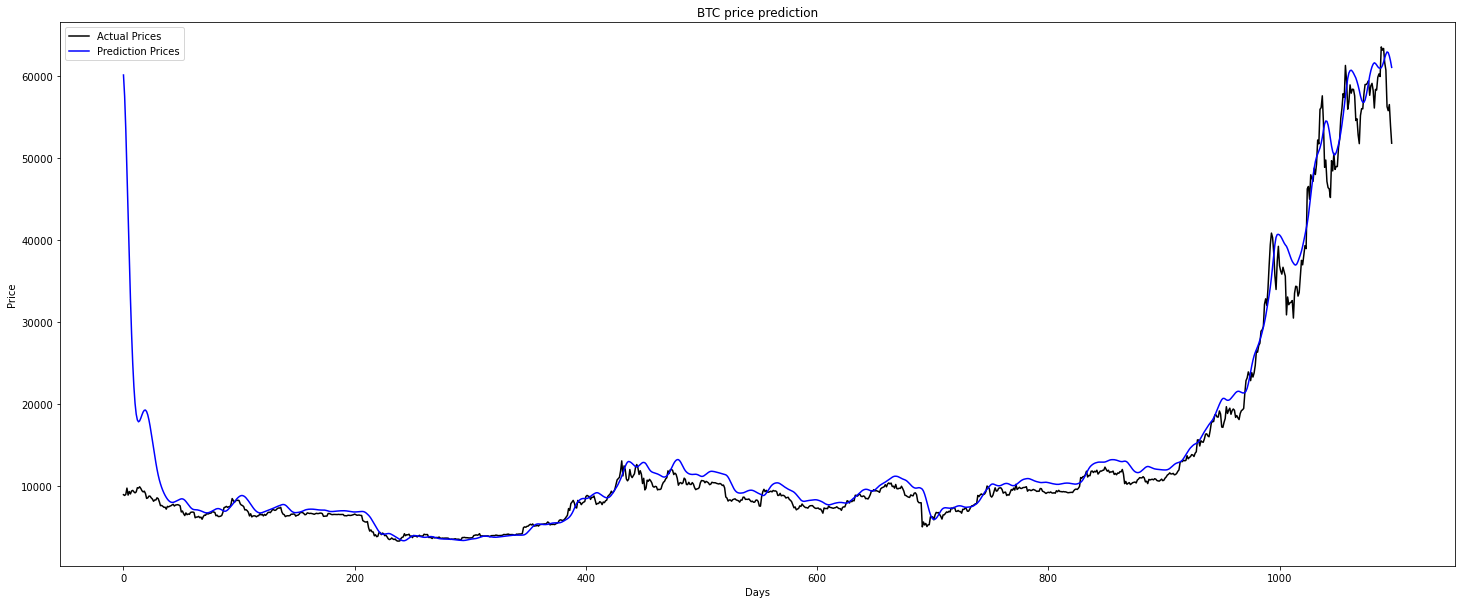

In [7]:
predicted, actual = preparation(df1)
#1 year

Epoch 1/25
39/39 [==============================] - 8s 69ms/step - loss: 0.0230
Epoch 2/25
39/39 [==============================] - 3s 64ms/step - loss: 0.0045
Epoch 3/25
39/39 [==============================] - 2s 63ms/step - loss: 0.0035
Epoch 4/25
39/39 [==============================] - 2s 63ms/step - loss: 0.0032
Epoch 5/25
39/39 [==============================] - 3s 68ms/step - loss: 0.0037
Epoch 6/25
39/39 [==============================] - 3s 66ms/step - loss: 0.0047
Epoch 7/25
39/39 [==============================] - 3s 67ms/step - loss: 0.0032
Epoch 8/25
39/39 [==============================] - 3s 65ms/step - loss: 0.0028
Epoch 9/25
39/39 [==============================] - 3s 65ms/step - loss: 0.0028
Epoch 10/25
39/39 [==============================] - 3s 66ms/step - loss: 0.0034
Epoch 11/25
39/39 [==============================] - 3s 65ms/step - loss: 0.0024
Epoch 12/25
39/39 [==============================] - 3s 65ms/step - loss: 0.0024
Epoch 13/25
39/39 [==================

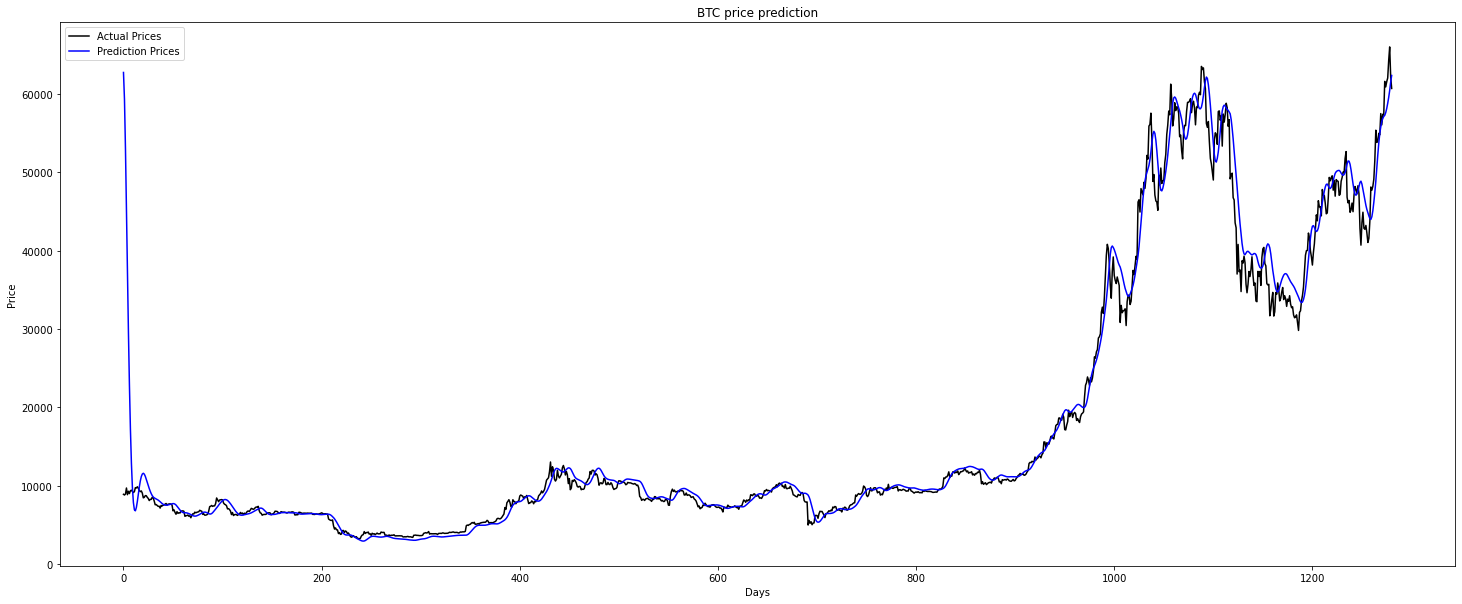

In [8]:
predicted, actual = preparation(df2)
#6 month

Epoch 1/25
33/33 [==============================] - 7s 61ms/step - loss: 0.0328
Epoch 2/25
33/33 [==============================] - 2s 62ms/step - loss: 0.0071
Epoch 3/25
33/33 [==============================] - 2s 63ms/step - loss: 0.0056
Epoch 4/25
33/33 [==============================] - 2s 65ms/step - loss: 0.0052
Epoch 5/25
33/33 [==============================] - 2s 66ms/step - loss: 0.0050
Epoch 6/25
33/33 [==============================] - 2s 67ms/step - loss: 0.0051
Epoch 7/25
33/33 [==============================] - 2s 73ms/step - loss: 0.0051
Epoch 8/25
33/33 [==============================] - 3s 76ms/step - loss: 0.0042
Epoch 9/25
33/33 [==============================] - 2s 73ms/step - loss: 0.0048
Epoch 10/25
33/33 [==============================] - 2s 69ms/step - loss: 0.0041
Epoch 11/25
33/33 [==============================] - 2s 73ms/step - loss: 0.0045
Epoch 12/25
33/33 [==============================] - 3s 76ms/step - loss: 0.0037
Epoch 13/25
33/33 [==================

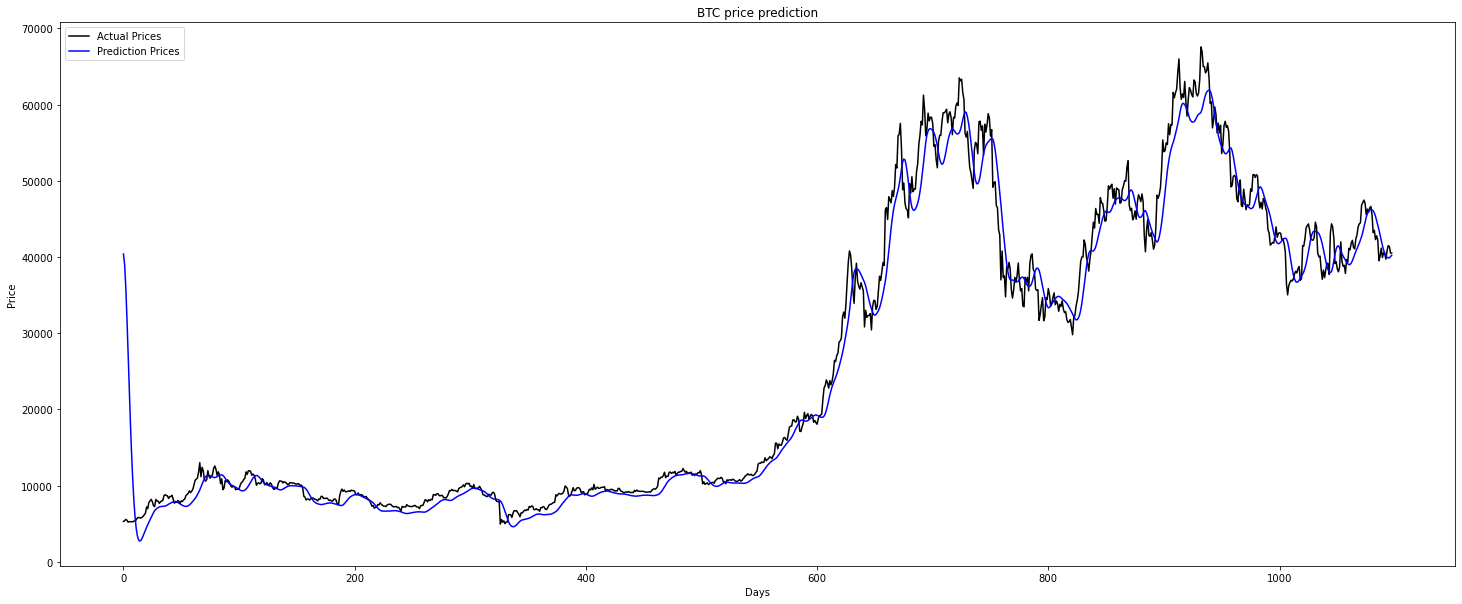

In [9]:
predicted, actual = preparation(df)
#future